In [244]:
import asyncio
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
from re import findall
from typing import Any

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from guess_raman_lines import (
    clustering_lines_intervals,
    find_interval_key,
    find_nearest,
    fit_model,
    fitting_model,
    guess_peaks,
    params_func_legend,
    show_distribution,
)
from lmfit import Model, Parameters
from lmfit.model import ModelResult
from numba import njit

# Import data

In [2]:
p = Path("cm-1").glob("**/*")
filenames = [x for x in p]

In [3]:
input_data = {}
for filename in filenames:
    n_array = np.loadtxt(filename)
    basename_of_file = Path(filename).name
    input_data[basename_of_file] = n_array

In [4]:
def get_group_number_from_filename(basename_with_group_number: str) -> int:
    """
    Using in import_spectrum only.
    Supported patterns: '1 filename.txt', '1_filename.asc', '[2]_filename.asc', '[2] filename.asc'
    @param basename_with_group_number: str - filename
    @return: int - group number
    """
    result_just_number = findall(r"^\d+", basename_with_group_number)
    result_square_brackets = get_result_square_brackets(basename_with_group_number)
    result_round_brackets = findall(r"^\(\d+\)", basename_with_group_number)
    if result_round_brackets:
        result_round_brackets = findall(r"\d", result_round_brackets[0])

    if result_just_number and result_just_number[0] != "":
        group_number_str = result_just_number[0]
    elif result_square_brackets and result_square_brackets[0] != "":
        group_number_str = result_square_brackets[0]
    elif result_round_brackets and result_round_brackets[0] != "":
        group_number_str = result_round_brackets[0]
    else:
        group_number_str = "0"

    return int(group_number_str)


def get_result_square_brackets(basename_with_group_number: str) -> list[Any]:
    result_square_brackets = findall(r"^\[\d]", basename_with_group_number)
    if result_square_brackets:
        result_square_brackets = findall(r"\d", result_square_brackets[0])
    return result_square_brackets

In [5]:
group_id_for_filenames = {}
for k in input_data.keys():
    group_id_for_filenames[k] = get_group_number_from_filename(k)

In [6]:
def create_averaged_df() -> pd.DataFrame:
    """
    Function creates DataFrame for seaborn line plot.

    Returns
    -------
    av_df: pd.DataFrame
        DataFrame with 3 columns:
            Label: group_id
            Raman shift: cm-1 for x-axis
            Intensity, rel. un.: y-axis value
    """
    av_df = pd.DataFrame(
        columns=[
            "Label",
            "Raman shift, cm\N{superscript minus}\N{superscript one}",
            "Intensity, rel. un.",
        ]
    )
    n_groups = len(np.unique(list(group_id_for_filenames.values())))
    groups_names = ["Mineralized", "Demineralized"]
    for i in range(n_groups):
        group_id = i + 1
        filenames = [k for k, v in group_id_for_filenames.items() if v == group_id]
        n_spectrum = len(filenames)
        if n_spectrum == 0:
            continue
        arrays_y = [input_data[x][:, 1] for x in filenames]
        arrays_y = np.array(arrays_y).flatten()
        x_axis = next(iter(input_data.values()))[:, 0]
        x_axis = np.array(x_axis)
        x_axis = np.tile(x_axis, n_spectrum)
        label = groups_names[i]
        labels = [label] * arrays_y.size
        df = pd.DataFrame(
            {
                "Label": labels,
                "Raman shift, cm\N{superscript minus}\N{superscript one}": x_axis,
                "Intensity, rel. un.": arrays_y,
            }
        )
        av_df = pd.concat([av_df, df])
    return av_df

Plot all imported spectra

<Axes: xlabel='Raman shift, cm⁻¹', ylabel='Intensity, rel. un.'>

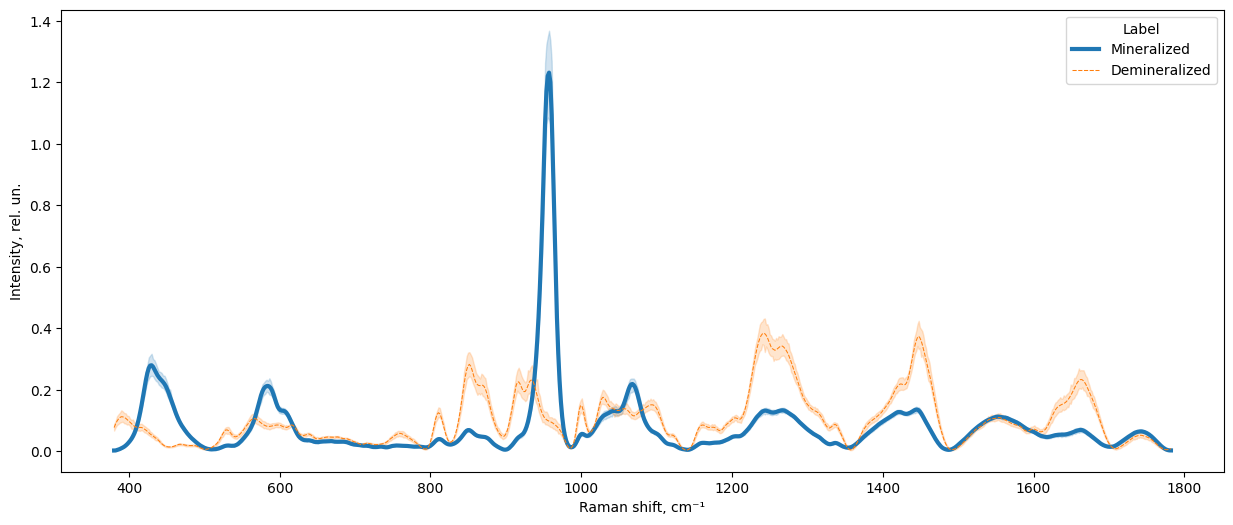

In [9]:
error_method = "ci"
error_level = 99
n_boot = 100
fig, ax = plt.subplots(figsize=(15, 6))
av_df = create_averaged_df()
sns.lineplot(
    data=av_df,
    x="Raman shift, cm\N{superscript minus}\N{superscript one}",
    y="Intensity, rel. un.",
    hue="Label",
    size="Label",
    style="Label",
    errorbar=(error_method, error_level),
    legend="full",
    ax=ax,
    n_boot=n_boot,
)

Averaged spectrum

<Axes: xlabel='Raman shift, cm⁻¹', ylabel='Intensity, rel. un.'>

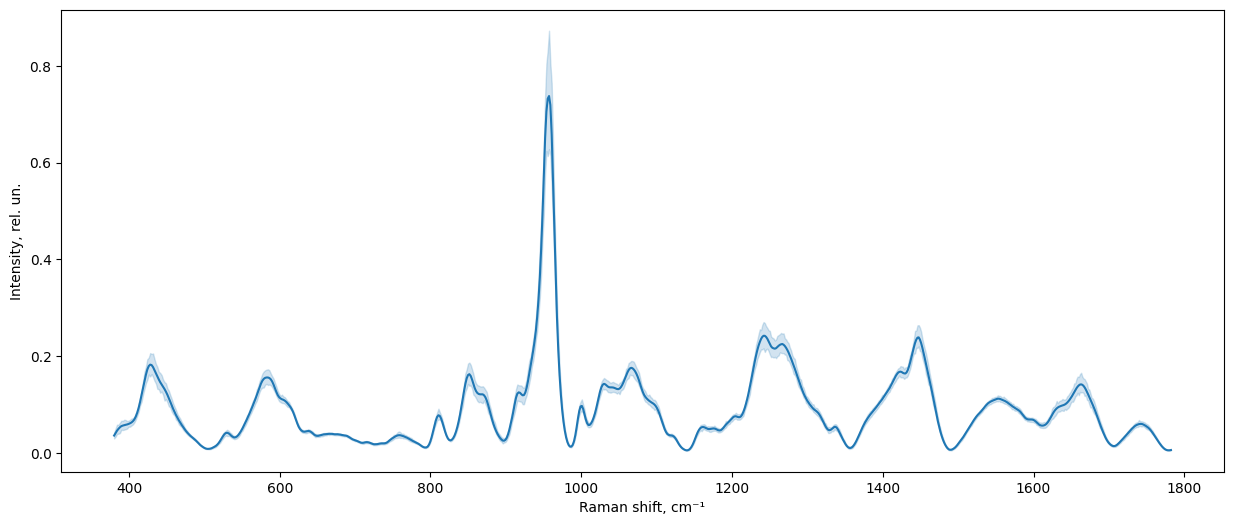

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    data=av_df,
    x="Raman shift, cm\N{superscript minus}\N{superscript one}",
    y="Intensity, rel. un.",
    errorbar=(error_method, error_level),
    legend="full",
    ax=ax,
    n_boot=n_boot,
)

# 1 Guess peaks iteratively

In [14]:
@njit(cache=True, fastmath=True)
def gaussian(x: np.ndarray, a: float, x0: float, dx: float) -> np.ndarray:
    """compute a Gaussian peak

    Inputs
    ------
    x : ndarray
        the positions at which the signal should be sampled
    a : float or ndarray with size equal to x.shape
        amplitude
    x0 : float or ndarray with size equal to x.shape
        frequency/position of the Gaussian component
    dx : float or ndarray with size equal to x.shape
        half-width at half-maximum

    Returns
    -------
    out : ndarray
        the signal

    Remarks
    -------
    Formula is a*np.exp(-np.log(2)*((x-x0)/dx)**2)
    """
    return a * np.exp(-np.log(2) * ((x - x0) / dx) ** 2)

In [15]:
def _init_model_params(line_type: str) -> list[float]:
    """
    Function returns list of initial parameter values.
    For param names ['a', 'x0', 'dx'] will return [float, float, float]

    Parameters
    ---------
    line_type : str
        {'Gaussian', 'Split Gaussian', ... etc}. Line type chosen by user in Guess button.
         Look peak_shapes_params() in default_values.py

    Returns
    -------
    out : list[float]
    """
    init_params = initial_peak_parameters(line_type)
    init_model_params = []
    for i, j in init_params.items():
        if i != "x_axis":
            init_model_params.append(j)
    return init_model_params

In [16]:
def get_average_spectrum(spectra: list[np.ndarray], method: str = "Mean") -> np.ndarray:
    """
    Returns mean / median spectrum for all spectra
    Parameters
    ----------
    spectra: list[np.ndarray]
       Contains lists of Raman spectra with 2 columns: x - cm-1, y - Intensity
    method: str
        'Mean' or 'Median'

    Returns
    -------
    np.ndarray
       averaged spectrum 2D (x, y)
    """
    assert spectra
    assert method in ["Mean", "Median"]
    x_axis = spectra[0][:, 0]
    y_axes = [spectrum[:, 1] for spectrum in spectra]
    y_axes = np.array(y_axes)
    np_y_axis = (
        np.mean(y_axes, axis=0) if method == "Mean" else np.median(y_axes, axis=0)
    )
    return np.vstack((x_axis, np_y_axis)).T

In [17]:
def initial_peak_parameters(line_type: str) -> dict:
    """
    The function returns dict with initial parameters and x_axis.
        'x_axis': np.ndarray, 'a': float, 'x0': float, 'dx': float, + additional parameters

    Parameters
    ----------
    line_type: str
        {'Gaussian', 'Split Gaussian', ... etc}. Line type chosen by user in Guess button.
         Look peak_shapes_params() in default_values.py

    Returns
    -------
    out : dict
        'x_axis': np.ndarray, 'a': float, 'x0': float, 'dx': float, + additional parameters
    """
    x_axis = np.array(range(920, 1080))
    arr = get_average_spectrum(list(input_data.values()))
    dx = 6.88407 * np.pi / 2
    x_axis = arr[:, 0]
    a = np.max(arr[:, 1]) / 2
    x0 = np.mean(x_axis)

    result = {
        "x_axis": x_axis,
        "a": np.round(a, 5),
        "x0": np.round(x0, 5),
        "dx": np.round(dx, 5),
    }
    return result

In [64]:
def _parameters_to_guess(line_type: str) -> dict:
    """
    Prepare parameters for send to guess_peaks()

    Parameters
    ---------
    line_type : str
        {'Gaussian', 'Split Gaussian', ... etc}. Line type chosen by user in Guess button.
         see peak_shapes_params() in default_values.py

    Returns
    -------
    out :
        dict with keys:
        'func': callable; Function for peak shape calculation. Look peak_shapes_params() in default_values.py.
        'param_names': list[str]; List of parameter names. Example: ['a', 'x0', 'dx'].
        'init_model_params': list[float]; Initial values of parameters for a given spectrum and line type.
        'min_fwhm': float; the minimum value FWHM, determined from the input table (the minimum of all).
        'method': str; Optimization method, see fitting_methods() in default_values.py.
        'params_limits': dict[str, tuple[float, float]]; see peak_shape_params_limits() in default_values.py.
        'noise_level': float; limit for peak detection.
            Peaks with amplitude less than noise_level will not be detected.
        'max_dx': float; Maximal possible value for dx. For all peaks.
        'gamma_factor: float;
             from 0. to 1. limit for max gamma value set by: max_v = min(dx_left, dx_right) * gamma_factor

    # The following parameters are empty if there are no lines. If at the beginning of the analysis there are
    # lines already created by the user, then the parameters will be filled.

        'func_legend': list[tuple]; - (callable func, legend),
            func - callable; Function for peak shape calculation. Look peak_shapes_params() in default_values.py.
            legend - prefix for the line in the model. All lines in a heap. As a result,
                we select only those that belong to the current interval.
        'params': Parameters(); parameters of existing lines.
        'used_legends': list[str]; already used legends (used wave-numbers)
            ['k977dot15_', 'k959dot68_', 'k917dot49_']. We control it because model cant have lines with duplicate
             legends (same x0 position lines)
        'used_legends_dead_zone': dict; keys - used_legends, values - tuple (idx - left idx, right idx - idx).
            dead zone size to set y_residual to 0.
            {'k977dot15_': (1, 1), 'k959dot68_': (2, 1), 'k917dot49_': (3, 4)}
    """
    func = gaussian
    param_names = ["a", "x0", "dx"]
    init_model_params = _init_model_params(line_type)
    func_legend = []
    params_limits = {
        "gamma": (0.0, 100.0),
        "skew": (-100.0, 100.0),
        "l_ratio": (0.0, 1.0),
        "expon": (0.1, 100.0),
        "beta": (0.1, 100.0),
        "alpha": (-1.0, 1.0),
        "q": (-0.5, 0.5),
    }
    params = Parameters()
    used_legends = []
    used_legends_dead_zone = {}
    return {
        "func": func,
        "param_names": param_names,
        "init_model_params": init_model_params,
        "min_fwhm": min_fwhm,
        "method": method,
        "noise_level": noise_level,
        "max_dx": max_dx,
        "params_limits": params_limits,
        "func_legend": func_legend,
        "params": params,
        "used_legends": used_legends,
        "used_legends_dead_zone": used_legends_dead_zone,
    }

In [150]:
line_type = "Gaussian"
min_fwhm = 6.30229
noise_level = 0.0074493
method = "least_squares"
max_dx = 12.0
borders = [503.908, 792.602, 1139.528, 1490.815]

In [93]:
averaged_spectrum = get_average_spectrum(list(input_data.values()))

In [66]:
parameters_to_guess = _parameters_to_guess(line_type)
parameters_to_guess

{'func': CPUDispatcher(<function gaussian at 0x00000245625BB250>),
 'param_names': ['a', 'x0', 'dx'],
 'init_model_params': [0.36874, 1109.36854, 10.81347],
 'min_fwhm': 6.30229,
 'method': 'least_squares',
 'noise_level': 0.0074493,
 'max_dx': 12.0,
 'params_limits': {'gamma': (0.0, 100.0),
  'skew': (-100.0, 100.0),
  'l_ratio': (0.0, 1.0),
  'expon': (0.1, 100.0),
  'beta': (0.1, 100.0),
  'alpha': (-1.0, 1.0),
  'q': (-0.5, 0.5)},
 'func_legend': [],
 'params': Parameters(),
 'used_legends': [],
 'used_legends_dead_zone': {}}

In [67]:
def _arrays_for_peak_guess() -> list[np.ndarray]:
    """
    The function return sliced spectra for guess peaks.
    If Guess method == 'Average' return only Averaged spectrum
    elif 'Average groups' - return spectra of average groups
    elif 'All' - return all spectra

    Returns
    -------
    out: list[ndarray]
        sliced spectra for guess peaks
    """
    arrays = {}
    for key, arr in input_data.items():
        arrays[key] = [arr]
    arrays_for_guess = _split_array_for_fitting(arrays).values()
    result = []
    for i in arrays_for_guess:
        for j in i:
            result.append(j)
    return result

In [68]:
def _split_array_for_fitting(
    arrays: dict[str, list[np.ndarray]]
) -> dict[str, list[np.ndarray]]:
    """
    The function cuts the spectra at intervals specified by the user.
    If checked 'interval' cut all spectra by this range
    elif 'Split by intervals': use intervals from table
    else: not selected range use input arrays as out without changes.

    Parameters
    ----------
    arrays: dict[str, list[np.ndarray]]
        filename, spectrum array with x_axis and y_axis

    Returns
    -------
    out: dict[str, list[np.ndarray]]
        same arrays but sliced
    """
    split_arrays = {}
    x_axis = next(iter(input_data.values()))[:, 0]
    intervals_idx = intervals_by_borders(borders, x_axis, idx=True)
    for key, arr in arrays.items():
        split_arrays[key] = split_by_borders(arr[0], intervals_idx)

    return split_arrays

In [69]:
def intervals_by_borders(
    borders: list[float], x_axis: np.ndarray, idx: bool = False
) -> list[tuple[float | int, float | int]]:
    """
    Values of intervals in x_axis. Borders given from BORDERS table set by user.

    Parameters
    ----------
    borders: list[float]
        borders of cm-1 ranges
    x_axis: np.ndarray
        common x_axis for all spectra given from any of baseline_corrected_dict
    idx: bool
        If true: return indexes, False - return values.

    Returns
    -------
    out: list[tuple[float, float]]

    Examples of output
    -------
    >>> x_axis = np.arange(11., 23.)
    >>> x_axis
    array([11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.])
    >>> borders = [14., 18.]
    >>> intervals_by_borders(borders, x_axis)
    [(0, 14.0), (14.0, 18.0), (18.0, 22.0)]
    >>> intervals_by_borders(borders, x_axis, idx=True)
    [(0, 3), (3, 7), (7, 11)]
    """
    v_in_range = []
    for i in borders:
        if x_axis[0] < i < x_axis[-1]:
            v = nearest_idx(x_axis, i) if idx else find_nearest(x_axis, i)
            v_in_range.append(v)
    res = [(0, v_in_range[0])]
    for i in range(len(v_in_range) - 1):
        res.append((v_in_range[i], v_in_range[i + 1]))
    last_el = x_axis.shape[0] - 1 if idx else x_axis[-1]
    res.append((v_in_range[-1], last_el))
    return res

In [70]:
@njit(cache=True, fastmath=True)
def nearest_idx(array: np.ndarray, value: float) -> int:
    """
    nearest_idx(array: np.ndarray, value: float)

    Return an index of value nearest to input value in array

    Parameters
    ---------
    array : 1D ndarray
        Search the nearest value in this array
    value : float
        Input value to compare with values in array

    Returns
    -------
    out : int
        Index of nearest value

    Examples
    --------
    >>> ar = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
    >>> nearest_idx(ar, 2.9)
    2
    """
    idx = np.abs(array - value).argmin()
    array_v = np.round(array[idx], 5)
    value_r = np.round(value, 5)
    if np.abs(array_v - value_r) > 1 and idx != 0:
        return idx - 1
    else:
        return idx

In [71]:
def split_by_borders(
    arr: np.ndarray, intervals: list[tuple[int, int]]
) -> list[np.ndarray]:
    """
    The function returns sliced array by given interval range.

    Parameters
    ----------
    arr: np.ndarray
        input array to slice

    intervals: list[tuple[int, int]]
        ranges (start, end) indexes

    Returns
    -------
    out : list[np.ndarray]
        arr sliced

    Examples
    --------
    >>> data = [[0., 1.], [1., 1.1], [2., 1.2], [3., 1.3], [4., 1.4], [5., 1.5], [6., 1.4], [7., 1.3], [8., 1.2]]
    >>> arr = np.array(data)
    >>> intervals = [(0, 2), (2, 5), (5, 8)]
    >>> split_by_borders(arr, intervals)
    [array([[0. , 1. ],
           [1. , 1.1]]), array([[2. , 1.2],
           [3. , 1.3],
           [4. , 1.4]]), array([[5. , 1.5],
           [6. , 1.4],
           [7. , 1.3]])]
    """
    x_axis = arr[:, 0]
    y_axis = arr[:, 1]
    arrays_sliced = []
    for idx_start, idx_end in intervals:
        arr = np.vstack((x_axis[idx_start:idx_end], y_axis[idx_start:idx_end])).T
        arrays_sliced.append(arr)
    return arrays_sliced

In [72]:
sliced_arrays = _arrays_for_peak_guess()

In [73]:
n_files = len(sliced_arrays)

In [74]:
loop = asyncio.get_running_loop()
current_executor = ProcessPoolExecutor()
with current_executor:
    current_futures = [
        loop.run_in_executor(current_executor, guess_peaks, arr, parameters_to_guess)
        for arr in sliced_arrays
    ]
    latest_guess_result = await asyncio.gather(*current_futures)

# 2 Find final model

In [183]:
async def _analyze_guess_results(
    result: list[ModelResult], param_names: list[str], line_type: str
) -> np.ndarray | Model:
    """
    The function creates structure for final fitting. After final fitting we have final template for deconvolution.

    Parameters
    ----------
    result: list[ModelResult]
        results of fitting for every spectrum and every interval range.

    param_names: list[str]
        Names of peak_shape parameters. Standard params are 'a', 'x0' and 'dx_right'. Other param names given from
         peak_shapes_params() in default_values.py

    line_type: str
        {'Gaussian', 'Split Gaussian', ... etc}. Line type chosen by user in Guess button.
         Look peak_shapes_params() in default_values.py

    Returns
    -------
    x_y_models_params: list[tuple[np.ndarray, np.ndarray, Model, Parameters]]
        result of self.models_params_after_guess()
    """
    intervals_data = _create_intervals_data(result, len(param_names))
    all_ranges_clustered_x0_sd = await clustering_lines_intervals(
        intervals_data, max_dx * 2
    )
    x_y_models_params = _models_params_after_guess(
        all_ranges_clustered_x0_sd, param_names, line_type
    )
    return x_y_models_params, intervals_data, all_ranges_clustered_x0_sd

In [184]:
def _create_intervals_data(
    result: list[ModelResult], peak_n_params: int
) -> dict[str, dict[str, tuple[float, float] | list]]:
    """
    The function creates intervals range and create_intervals_data.

    Parameters
    ----------
    result: list[ModelResult]
        results of fitting for every spectrum and every interval range.

    peak_n_params: int
        number of parameters of peak shape. Look peak_shapes_params() in default_values.py

    Returns
    -------
    data_by_intervals: dict[dict]
        with keys 'interval': (start, end), 'x0': list, lines_count': []
    """
    # create intervals for create_intervals_data()
    x_axis = next(iter(input_data.values()))[:, 0]
    intervals = intervals_by_borders(borders, x_axis)
    data_by_intervals = create_intervals_data(result, peak_n_params, intervals)
    return data_by_intervals

In [185]:
def create_intervals_data(
    model_result: list[ModelResult],
    peak_n_params: int,
    intervals: list[tuple[float, float]],
) -> dict[str, dict[str, tuple[float, float] | list]]:
    """
    The function creates a structure with 'interval': (start cm-1, end cm-1), x0': list of x0 lines, lines_count': [].
    The result of the function is then passed to clustering_lines_intervals()

    Parameters
    ----------
    model_result: list[ModelResult]
        results of fitting for every spectrum and every interval range.

    peak_n_params: int
        number of parameters of peak shape. Look peak_shapes_params() in default_values.py

    intervals: list[tuple[float, float]]
        Values of intervals in x_axis. Borders given from BORDERS table set by user.
        Result of intervals_by_borders_values()

    Returns
    -------
    data_by_intervals: dict[dict]
        with keys 'interval': (start, end), 'x0': list, lines_count': []
    """
    data_by_intervals = {}
    for start, end in intervals:
        key = str(round(start)) + "_" + str(round(end))
        data_by_intervals[key] = {"interval": (start, end), "x0": [], "lines_count": []}
    for fit_result in model_result:
        if not fit_result:
            warning("None fit_result")
            continue
        parameters = fit_result.params
        lines_count = int(len(parameters) / peak_n_params)
        interval_key = None
        for j, par in enumerate(parameters):
            str_split = par.split("_", 1)
            param_name = str_split[1]
            if j == len(parameters) - 1 and interval_key is not None:
                data_by_intervals[interval_key]["lines_count"].append(lines_count)
            if param_name != "x0":
                continue
            x0 = parameters[par].value
            interval_key = find_interval_key(x0, data_by_intervals)
            if interval_key is None:
                continue
            data_by_intervals[interval_key]["x0"].append(x0)
    return data_by_intervals

In [186]:
def _models_params_after_guess(
    all_ranges_clustered_x0_sd: list[np.ndarray], param_names: list[str], line_type: str
) -> list[tuple[np.ndarray, np.ndarray, Model, Parameters]]:
    """
    Preparation of sliced x_axis, y_axis of averaged spectrum, fit model and parameters from a list of wave numbers,
     divided into ranges.

    Parameters
    ----------
    all_ranges_clustered_x0_sd: list[ndarray]
        result of estimate_n_lines_in_range(x0, hwhm) for each range
        2D array with 2 columns: center of cluster x0 and standard deviation of each cluster

    param_names: list[str]
        Names of peak_shape parameters. Standard params are 'a', 'x0' and 'dx_right'. Other param names given from
         peak_shapes_params() in default_values.py

    line_type: str
        {'Gaussian', 'Split Gaussian', ... etc}. Line type chosen by user in Guess button.
         Look peak_shapes_params() in default_values.py

    Returns
    -------
    x_y_models_params: list[tuple[np.ndarray, np.ndarray, Model, Parameters]]
        tuples with x_axis, y_axis, fitting model, params for fitting model. For each cm-1 range.
    """
    sliced_average_array_by_ranges = _split_array_for_fitting(
        {"Average": [averaged_spectrum]}
    )["Average"]

    # form static_params for all ranges
    init_params = initial_peak_parameters(line_type)

    _min_hwhm = min_fwhm / 2.0
    func = gaussian
    peak_shape_params_limits = {
        "gamma": (0.0, 100.0),
        "skew": (-100.0, 100.0),
        "l_ratio": (0.0, 1.0),
        "expon": (0.1, 100.0),
        "beta": (0.1, 100.0),
        "alpha": (-1.0, 1.0),
        "q": (-0.5, 0.5),
    }
    static_params = (
        init_params,
        max_dx,
        _min_hwhm,
        func,
        peak_shape_params_limits,
        param_names,
        0.25,
    )
    x_y_model_params = []
    for i, cur_range_clustered_x0_sd in enumerate(all_ranges_clustered_x0_sd):
        n_array = sliced_average_array_by_ranges[i]
        x_axis = n_array[:, 0]
        y_axis = n_array[:, 1]
        params, func_legend = params_func_legend(
            cur_range_clustered_x0_sd, n_array, static_params
        )
        model = fitting_model(func_legend)
        x_y_model_params.append((x_axis, y_axis, model, params))
    return x_y_model_params

In [187]:
x_y_models_params, intervals_data, all_ranges_clustered_x0_sd = (
    await _analyze_guess_results(
        latest_guess_result, parameters_to_guess["param_names"], line_type
    )
)

# Fit on averaged spectrum

In [188]:
current_executor = ProcessPoolExecutor()
with current_executor:
    current_futures = [
        loop.run_in_executor(
            current_executor,
            fit_model,
            i[2],
            i[1],
            i[3],
            i[0],
            parameters_to_guess["method"],
        )
        for i in x_y_models_params
    ]
    result = await asyncio.gather(*current_futures)

In [189]:
def edited_fit_report(fit_report: str) -> str:
    if "[[Fit Statistics]]" in fit_report:
        idx = fit_report.find("[[Fit Statistics]]")
        fit_report = fit_report[idx:]
    fit_report += "\n" + "\n"
    fit_report = fit_report.replace("dot", ".")
    return fit_report

In [190]:
_fit_report = ""
for model_result in result:
    _fit_report += edited_fit_report(model_result.fit_report(show_correl=False))

# Show result

In [191]:
for line in _fit_report.split("\n"):
    print(line)

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 323
    # data points      = 65
    # variables        = 18
    chi-square         = 5.1848e-05
    reduced chi-square = 1.1031e-06
    Akaike info crit   = -876.703215
    Bayesian info crit = -837.564244
    R-squared          = 0.99969619
[[Variables]]
    k390.52_a:   0.04342856 +/- 0.08369673 (192.72%) (init = 0.18229)
    k390.52_x0:  387.488450 +/- 19.9246682 (5.14%) (init = 390.5191)
    k390.52_dx:  12.0000000 +/- 9.00135957 (75.01%) (init = 12)
    k402.02_a:   0.04016761 +/- 0.10386671 (258.58%) (init = 0.18229)
    k402.02_x0:  405.428207 +/- 10.6534440 (2.63%) (init = 402.0228)
    k402.02_dx:  11.9999977 +/- 22.4319519 (186.93%) (init = 12)
    k427.71_a:   0.16611678 +/- 0.06762452 (40.71%) (init = 0.18229)
    k427.71_x0:  427.373240 +/- 1.45999319 (0.34%) (init = 427.7096)
    k427.71_dx:  12.0000000 +/- 4.33842713 (36.15%) (init = 12)
    k450.77_a:   0.10513289 +/- 0.05204757 (49.51%) 

In [192]:
groups_colors = ["blue", "red"]

In [193]:
def update_averaged_dict() -> dict:
    """
    averaged_dict with key = group_id
    and values = averages spectrum of this group
    Returns
    -------
        None
    """
    n_groups = len(np.unique(list(group_id_for_filenames.values())))
    averaged_dict = {}
    averaging_method = "Mean"
    for i in range(n_groups):
        group_id = i + 1
        filenames = [k for k, v in group_id_for_filenames.items() if v == group_id]
        if len(filenames) == 0:
            continue
        arrays_list = [input_data[x] for x in filenames if x in input_data]
        if not arrays_list:
            continue
        arrays_list_av = get_average_spectrum(arrays_list, averaging_method)
        averaged_dict[group_id] = arrays_list_av
    return averaged_dict

In [194]:
averaged_dict = update_averaged_dict()

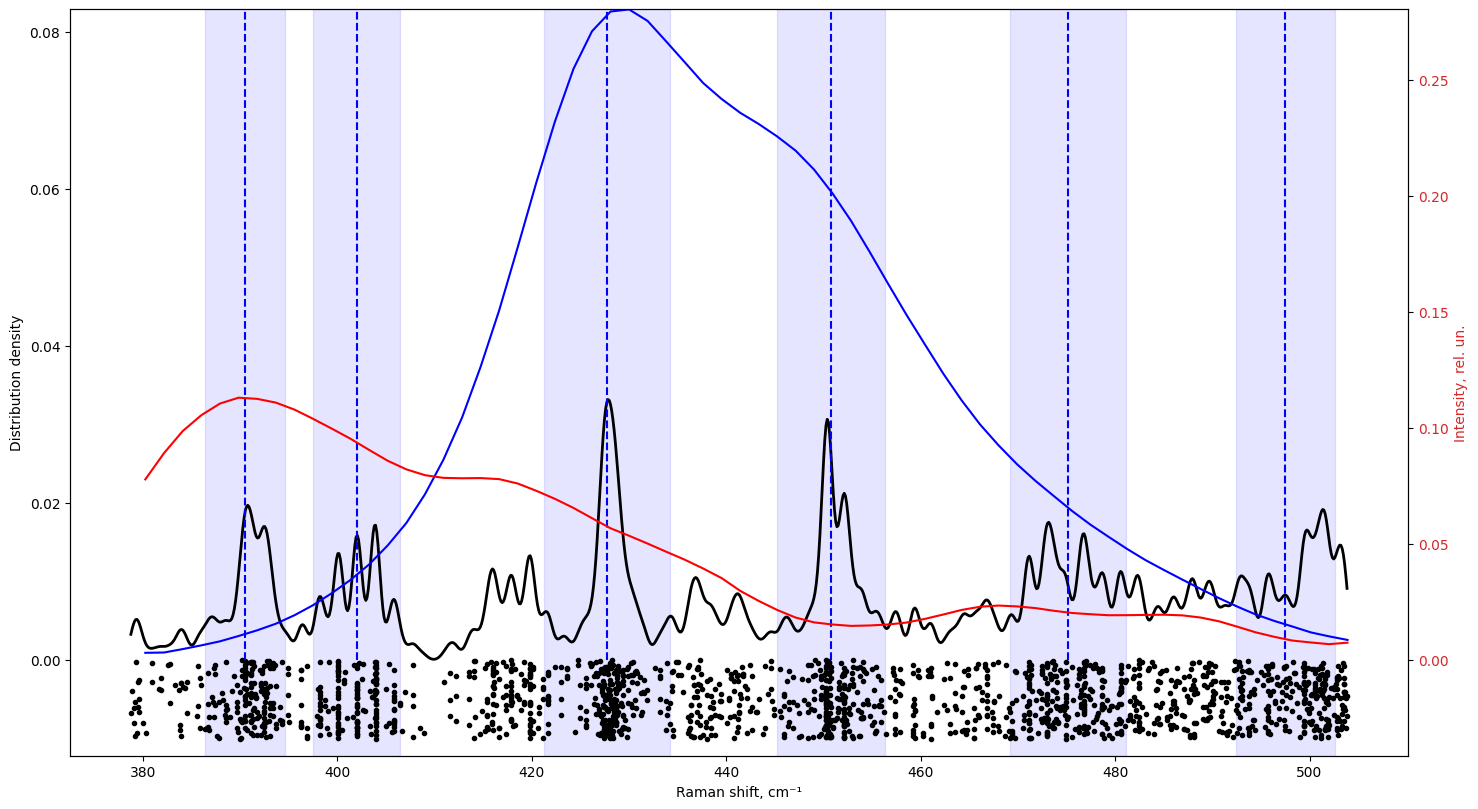

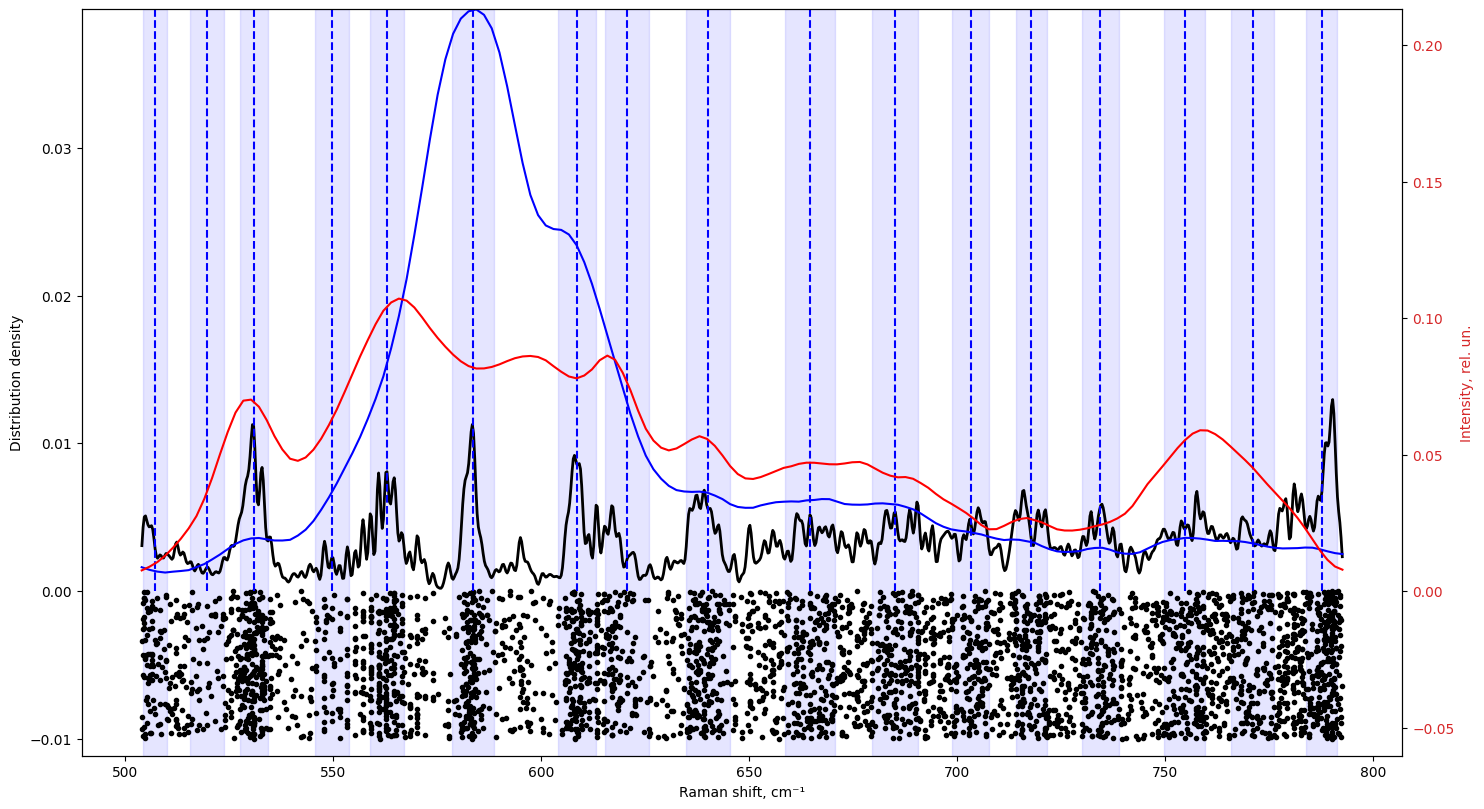

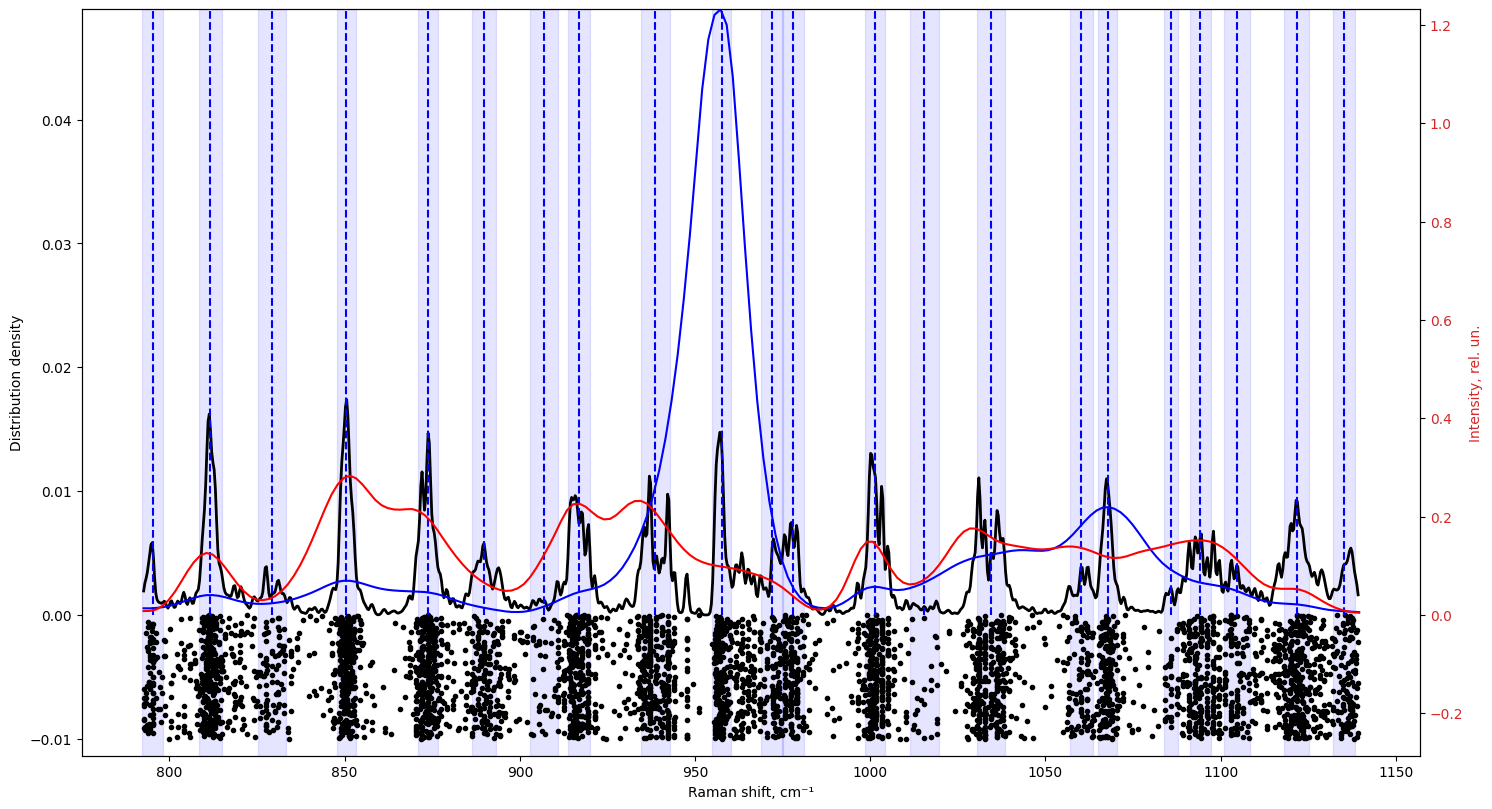

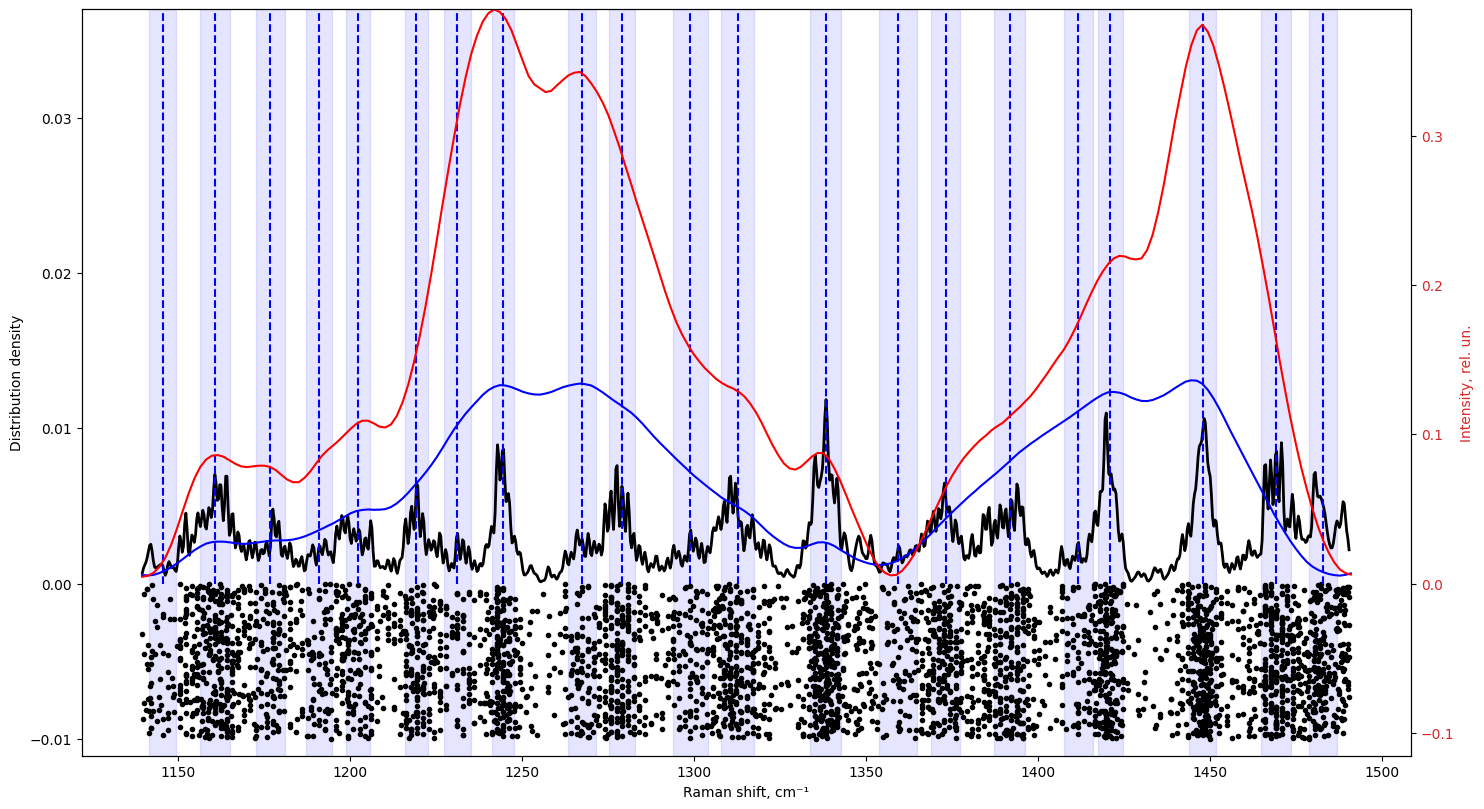

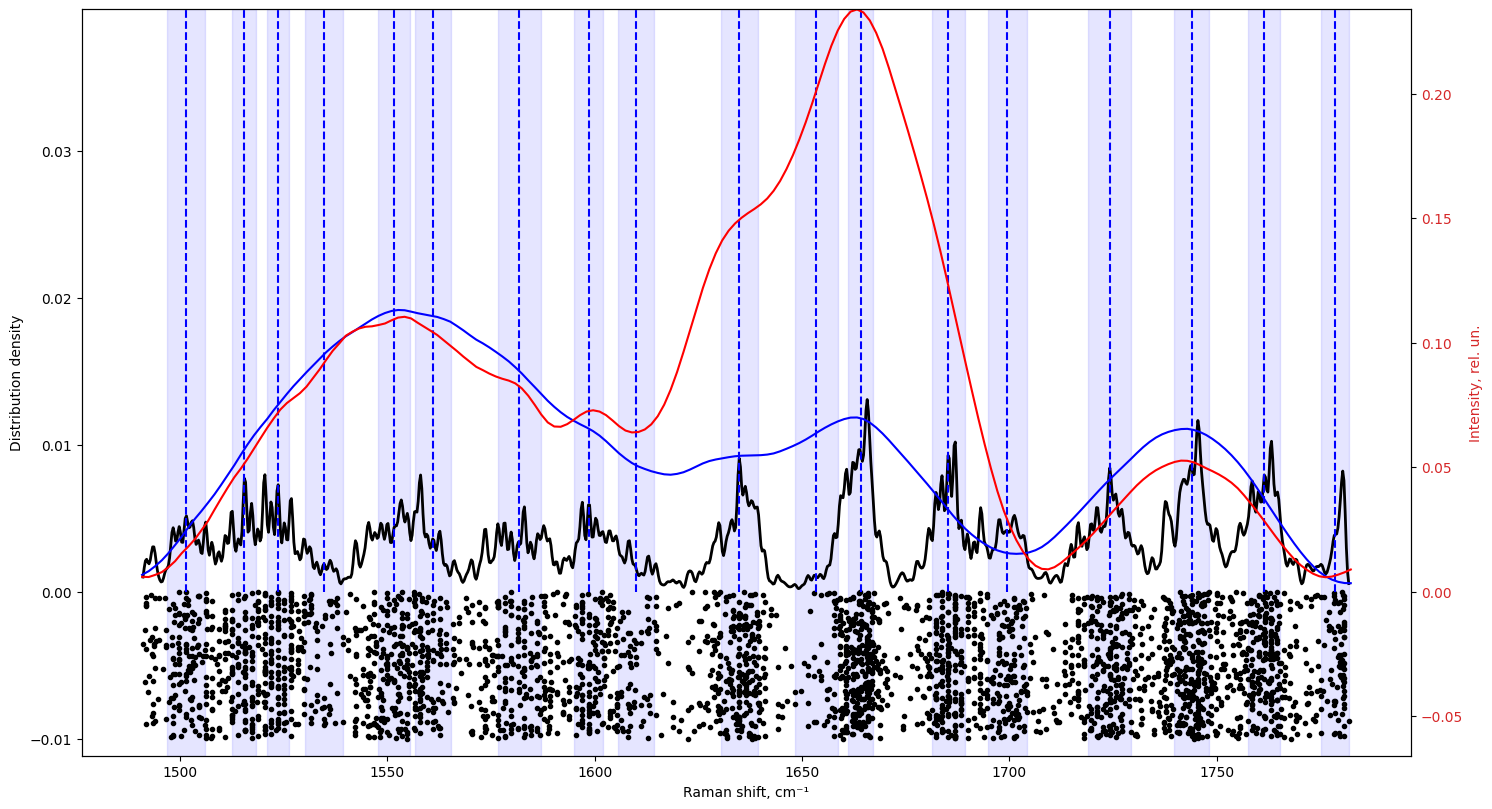

In [264]:
plt.rcParams["figure.figsize"] = (15, 8)
for i, v in enumerate(intervals_data.items()):
    key, item = v
    show_distribution(
        item["x0"],
        averaged_dict,
        all_ranges_clustered_x0_sd[i],
        groups_colors,
    )

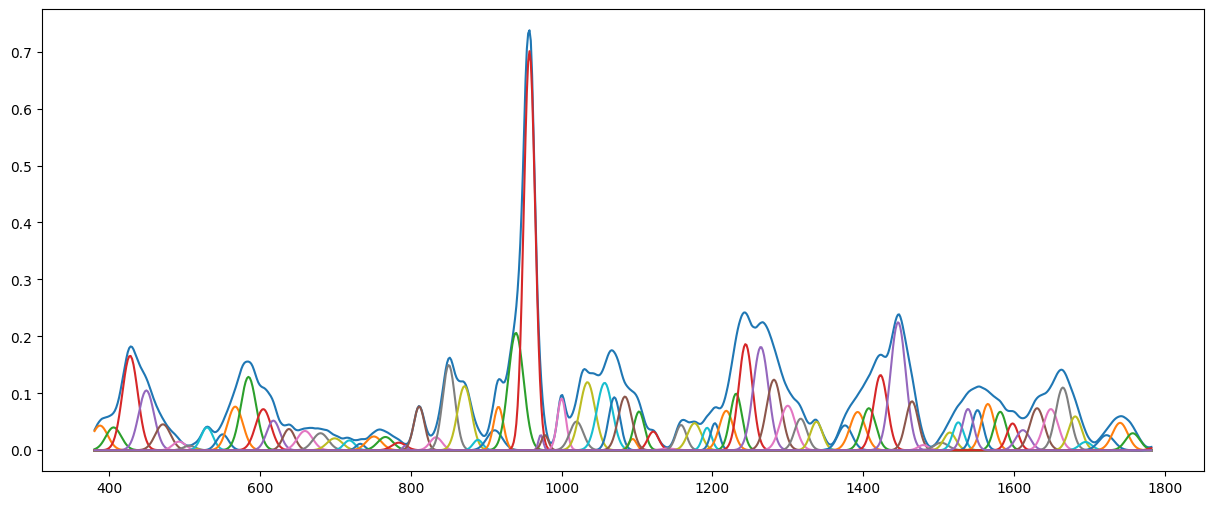

In [255]:
fig, ax = plt.subplots(figsize=(15, 6))
x = averaged_spectrum[:, 0]
plt.plot(x, averaged_spectrum[:, 1]);

for res in result:
    values = list(res.values.values())
    for i in range(0, len(values), 3):
        y = gaussian(x, values[i], values[i + 1], values[i + 2])
        plt.plot(x, y)